In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [7]:
df = pd.read_csv("attribution_data.csv")
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [9]:
def time_decay_attribution(df, conv_col, channel_col, user_id, time_col, decay_rate=0.5):
    """
    Time Decay Attribution Model
    """
    # Step 1: Filter data for converted users
    converted_users = df[df[conv_col] == 1][user_id].unique()
    df_conv = df[df[user_id].isin(converted_users)].copy()

    # Step 2: Sort touchpoints by user and time
    df_conv['time'] = pd.to_datetime(df_conv[time_col])
    df_conv = df_conv.sort_values(by=[user_id, 'time'])

    # Step 3: Calculate the number of touchpoints and their relative time to the conversion event
    df_conv['conversion_time'] = df_conv.groupby(user_id)['time'].transform('max')
    df_conv['time_diff'] = (df_conv['conversion_time'] - df_conv['time']).dt.total_seconds()

    # Step 4: Calculate the decay weight for each touchpoint
    def calculate_decay_weight(time_diff, decay_rate):
        return np.exp(-decay_rate * time_diff)

    # Apply the decay function
    df_conv['decay_weight'] = df_conv['time_diff'].apply(lambda x: calculate_decay_weight(x, decay_rate))

    # Step 5: Normalize the weights so that the sum of all weights is 100%
    total_weight = df_conv.groupby(user_id)['decay_weight'].transform('sum')
    df_conv['normalized_weight'] = round(df_conv['decay_weight'] / total_weight * 100, 2)

    # Step 6: Aggregate the results by channel
    channel_weights = df_conv.groupby(channel_col)['normalized_weight'].sum().reset_index()

    # Step 7: Sort channels by their total weight in descending order
    channel_weights = channel_weights.sort_values(by='normalized_weight', ascending=False).reset_index(drop=True)
    
    return channel_weights

In [15]:
# Run the Time Decay Attribution Model
decay_result = time_decay_attribution(df, 'conversion', 'channel', 'cookie', 'time', decay_rate=0.1)
# Convert weights to percentages
decay_result['Weight (%)'] = round((decay_result['normalized_weight'] / decay_result['normalized_weight'].sum()) * 100, 2)
decay_result.set_index('channel')

,normalized_weight,Weight (%)
channel,,
Facebook,529643.04,30.03
Paid Search,454985.36,25.79
Online Video,340805.61,19.32
Instagram,224649.40,12.74
Online Display,213816.54,12.12


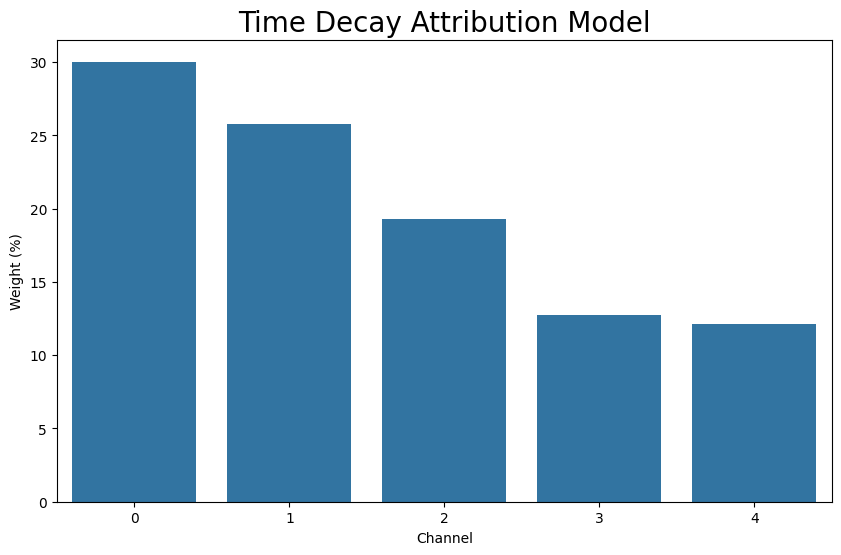

In [18]:
plt.subplots(figsize=(10, 6))
sns.barplot(data=decay_result, x=decay_result.index, y="Weight (%)")
plt.xlabel("Channel")
plt.title("Time Decay Attribution Model",fontsize=20)
plt.savefig('plot/time_decay_model.png')